# Scan MERRA-2 atmospheric properties during one year
----------------------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation January 12 2017
- update January 12 2016
- update April 25th 2018

Link:

http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release

### purpose:

Scan One year of MERRA-2 predictions of the dataset tavg1_2d_aer_Nx_M2T1NXAER. 
Extract the relevant atmospheric variables.
Build the correcponding time series and dataset in pandas.
Plot the variables. Save the pandas dataset into a file.
Convert the pandas dataset into an astropy fits table and save into a fits file as well.



## 1) python libraries
---------------------------

In [1]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "axes.color_cycle" on line 215 in
templates/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import datetime

In [3]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [4]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [5]:
import os
import re
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table

In [7]:
import h5py

In [8]:
import libGMAOMERRA2Data as merra2  # My own library

In [9]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 2)  Configuration
-------------------------

### SELECT YEAR

In [10]:
YEARNUM="2018"

In [11]:
# SELECT OBSERVATORY
OBS_NAME='ohp'

In [12]:
# where are the HDF files
#HDFEOS_ZOO_DIR="/Volumes/DAGORETBACK/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM/2016"
#HDFEOS_ZOO_DIR="/Volumes/LaCie2/DATA/MERRA-2/tavg1_2d_aer_Nx_M2T1NXAER"
#HDFEOS_ZOO_DIR="/sps/lsst/data/AtmosphericCalibration/MERRA-2/May-Jun-2017/subset_M2T1NXAER_V5.12.4_20180424_195815"
HDFEOS_ZOO_DIR="/Users/dagoret/DATA/MERRA-2/M2T1NXAER.5.12.4"

In [13]:
path=HDFEOS_ZOO_DIR

In [14]:
path=os.path.join(path,YEARNUM)

### Here I describe the content of the input files

In [15]:
DATA_TAG=['TOTANGSTR','TOTEXTTAU','TOTSCATAU']

In [16]:
DATA_TITLE=['Total Aerosol Angstrom parameter 470-870 nm',
            'Total Aerosol Extinction AOT 550 nm',
            'Total Aerosol Scattering AOT 550 nm'
           ]

In [17]:
NB_DATAFIELDS=len(DATA_TAG)

### List of output files

In [18]:
# The selected data field
DATA_NAME =  'tavg1_2d_aer_Nx_M2T1NXAER'   # 

In [19]:
pandas_filename='MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'.csv'

In [20]:
fits_filename='MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear' +'.fits'

In [21]:
# 6 output files for figures
figfile_aer_angstr='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_'+'AllYear'+'_aer_angstr'+'.png'
figfile_aer_extinct='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_'+'AllYear'+'_aer_extinct'+'.png'
figfile_aer_scatter='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_'+'AllYear'+'_aer_scatter'+'.png'

### Select where in the world

In [22]:
# Select observatory
loc=merra2.observatory_location(OBS_NAME)

In [23]:
loc

(5.71222222222, 43.9316666667, 650.0)

### 2.2) Getting the list of the files
------------------------------

In [24]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  

In [25]:
nc4_files[:5]

['MERRA2_400.tavg1_2d_aer_Nx.20180101.nc4',
 'MERRA2_400.tavg1_2d_aer_Nx.20180102.nc4',
 'MERRA2_400.tavg1_2d_aer_Nx.20180103.nc4',
 'MERRA2_400.tavg1_2d_aer_Nx.20180104.nc4',
 'MERRA2_400.tavg1_2d_aer_Nx.20180105.nc4']

### 2.3) Select files of a given month

In [26]:
keysel_filename='^MERRA2_400.tavg1_2d_aer_Nx.'+YEARNUM+'.*'

In [27]:
print 'Selection key' ,keysel_filename

Selection key ^MERRA2_400.tavg1_2d_aer_Nx.2018.*


In [28]:
nc4_files2 = []
for file in nc4_files:
    if re.findall(keysel_filename,file):
        nc4_files2.append(file)

nc4_files2=np.array(nc4_files2)

In [29]:
nc4_files2

array(['MERRA2_400.tavg1_2d_aer_Nx.20180101.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180102.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180103.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180104.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180105.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180106.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180107.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180108.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180109.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180110.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180111.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180112.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180113.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180114.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180115.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180116.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180117.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180118.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180119.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20180120.nc4',


### 2.4) Sort files by increasing time

In [30]:
nc4_files=np.sort(nc4_files2)

### 2.5) Build the full filename before reading

In [31]:
NBFILES=len(nc4_files)
full_nc4files=[]

for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4files.append(fname)  

## 3)  Extract data and write them into pandas dataset and time series
--------------------------------------------------------------------------------------

In [32]:
ts0=[]  # intermediate data series
ts1=[]
ts2=[]


df_tavg1_2d_aer_Nx=[] # final pandas dataset for all atmospheric quantities

for file in full_nc4files: # loop on data file of each day of the month
    
    #Retrieve 1D parameters longitude, latitude, time
    (m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(file,'lat') # latitude (array, unit, name)
    m_latitude = m_lat[:]
    (m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(file,'lon') # longitude(array, unit, name)
    m_longitude = m_lon[:]
    (m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(file,'time') # time (array, unit, name)
    m_time=m_tim[:]
       
    NbDataPerFile=m_time.shape[0] # number of data sample per file
    #start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",m_un_tim) # extract start time
    start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)",m_un_tim) # extract start time
    
    #print 'start_time = ', start_time
    time_rng = pd.date_range(start_time[0], periods=NbDataPerFile, freq='H') # one data per hour
    
    print '---------------------------------------------'
    print 'NbDataPerFile = ', NbDataPerFile
    print 'start_time = ', start_time
    print 'time_rng   = ', time_rng[:5]
    
    m_X,m_Y=np.meshgrid(m_longitude,m_latitude) # build meash-grid in longitude and latitude
    (sel_long, sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1]) # get bin in longitude and latitude for the site  
    
 
    # loop
    for index in range(NB_DATAFIELDS):
        (m_data,m_unit,m_longname)=merra2.GetGeoRefData(file,DATA_TAG[index]) # 3D array : time x longitude x latitude  
        dt=m_data[:,sel_lat,sel_long]
        if index==0:
            ts0 = pd.Series(dt, index=time_rng)
        elif index==1:
            ts1 = pd.Series(dt, index=time_rng)
        elif index==2:
            ts2 = pd.Series(dt, index=time_rng)

            
        #clf_timeseries.append(ts)
        # Create the dataframe
    df = pd.DataFrame({DATA_TAG[0]: ts0, 
                       DATA_TAG[1]: ts1,
                       DATA_TAG[2]: ts2 }, index=time_rng)
    df_tavg1_2d_aer_Nx.append(df)  
    

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-01-01 00:30:00']
time_rng   =  DatetimeIndex(['2018-01-01 00:30:00', '2018-01-01 01:30:00',
               '2018-01-01 02:30:00', '2018-01-01 03:30:00',
               '2018-01-01 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-01-02 00:30:00']
time_rng   =  DatetimeIndex(['2018-01-02 00:30:00', '2018-01-02 01:30:00',
               '2018-01-02 02:30:00', '2018-01-02 03:30:00',
               '2018-01-02 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-01-03 00:30:00']
time_rng   =  DatetimeIndex(['2018-01-03 00:30:00', '2018-01-03 01:30:00',
               '2018-01-03 02:30:00', '2018-01-03 03:30:00',
               '2018-01-03 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-01-27 00:30:00']
time_rng   =  DatetimeIndex(['2018-01-27 00:30:00', '2018-01-27 01:30:00',
               '2018-01-27 02:30:00', '2018-01-27 03:30:00',
               '2018-01-27 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-01-28 00:30:00']
time_rng   =  DatetimeIndex(['2018-01-28 00:30:00', '2018-01-28 01:30:00',
               '2018-01-28 02:30:00', '2018-01-28 03:30:00',
               '2018-01-28 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-01-29 00:30:00']
time_rng   =  DatetimeIndex(['2018-01-29 00:30:00', '2018-01-29 01:30:00',
               '2018-01-29 02:30:00', '2018-01-29 03:30:00',
               '2018-01-29 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-02-22 00:30:00']
time_rng   =  DatetimeIndex(['2018-02-22 00:30:00', '2018-02-22 01:30:00',
               '2018-02-22 02:30:00', '2018-02-22 03:30:00',
               '2018-02-22 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-02-23 00:30:00']
time_rng   =  DatetimeIndex(['2018-02-23 00:30:00', '2018-02-23 01:30:00',
               '2018-02-23 02:30:00', '2018-02-23 03:30:00',
               '2018-02-23 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-02-24 00:30:00']
time_rng   =  DatetimeIndex(['2018-02-24 00:30:00', '2018-02-24 01:30:00',
               '2018-02-24 02:30:00', '2018-02-24 03:30:00',
               '2018-02-24 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-03-20 00:30:00']
time_rng   =  DatetimeIndex(['2018-03-20 00:30:00', '2018-03-20 01:30:00',
               '2018-03-20 02:30:00', '2018-03-20 03:30:00',
               '2018-03-20 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-03-21 00:30:00']
time_rng   =  DatetimeIndex(['2018-03-21 00:30:00', '2018-03-21 01:30:00',
               '2018-03-21 02:30:00', '2018-03-21 03:30:00',
               '2018-03-21 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-03-22 00:30:00']
time_rng   =  DatetimeIndex(['2018-03-22 00:30:00', '2018-03-22 01:30:00',
               '2018-03-22 02:30:00', '2018-03-22 03:30:00',
               '2018-03-22 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-04-15 00:30:00']
time_rng   =  DatetimeIndex(['2018-04-15 00:30:00', '2018-04-15 01:30:00',
               '2018-04-15 02:30:00', '2018-04-15 03:30:00',
               '2018-04-15 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-04-16 00:30:00']
time_rng   =  DatetimeIndex(['2018-04-16 00:30:00', '2018-04-16 01:30:00',
               '2018-04-16 02:30:00', '2018-04-16 03:30:00',
               '2018-04-16 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-04-17 00:30:00']
time_rng   =  DatetimeIndex(['2018-04-17 00:30:00', '2018-04-17 01:30:00',
               '2018-04-17 02:30:00', '2018-04-17 03:30:00',
               '2018-04-17 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-05-11 00:30:00']
time_rng   =  DatetimeIndex(['2018-05-11 00:30:00', '2018-05-11 01:30:00',
               '2018-05-11 02:30:00', '2018-05-11 03:30:00',
               '2018-05-11 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-05-12 00:30:00']
time_rng   =  DatetimeIndex(['2018-05-12 00:30:00', '2018-05-12 01:30:00',
               '2018-05-12 02:30:00', '2018-05-12 03:30:00',
               '2018-05-12 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-05-13 00:30:00']
time_rng   =  DatetimeIndex(['2018-05-13 00:30:00', '2018-05-13 01:30:00',
               '2018-05-13 02:30:00', '2018-05-13 03:30:00',
               '2018-05-13 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-06-06 00:30:00']
time_rng   =  DatetimeIndex(['2018-06-06 00:30:00', '2018-06-06 01:30:00',
               '2018-06-06 02:30:00', '2018-06-06 03:30:00',
               '2018-06-06 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-06-07 00:30:00']
time_rng   =  DatetimeIndex(['2018-06-07 00:30:00', '2018-06-07 01:30:00',
               '2018-06-07 02:30:00', '2018-06-07 03:30:00',
               '2018-06-07 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-06-08 00:30:00']
time_rng   =  DatetimeIndex(['2018-06-08 00:30:00', '2018-06-08 01:30:00',
               '2018-06-08 02:30:00', '2018-06-08 03:30:00',
               '2018-06-08 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-07-02 00:30:00']
time_rng   =  DatetimeIndex(['2018-07-02 00:30:00', '2018-07-02 01:30:00',
               '2018-07-02 02:30:00', '2018-07-02 03:30:00',
               '2018-07-02 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-07-03 00:30:00']
time_rng   =  DatetimeIndex(['2018-07-03 00:30:00', '2018-07-03 01:30:00',
               '2018-07-03 02:30:00', '2018-07-03 03:30:00',
               '2018-07-03 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-07-04 00:30:00']
time_rng   =  DatetimeIndex(['2018-07-04 00:30:00', '2018-07-04 01:30:00',
               '2018-07-04 02:30:00', '2018-07-04 03:30:00',
               '2018-07-04 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-07-28 00:30:00']
time_rng   =  DatetimeIndex(['2018-07-28 00:30:00', '2018-07-28 01:30:00',
               '2018-07-28 02:30:00', '2018-07-28 03:30:00',
               '2018-07-28 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-07-29 00:30:00']
time_rng   =  DatetimeIndex(['2018-07-29 00:30:00', '2018-07-29 01:30:00',
               '2018-07-29 02:30:00', '2018-07-29 03:30:00',
               '2018-07-29 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-07-30 00:30:00']
time_rng   =  DatetimeIndex(['2018-07-30 00:30:00', '2018-07-30 01:30:00',
               '2018-07-30 02:30:00', '2018-07-30 03:30:00',
               '2018-07-30 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-08-23 00:30:00']
time_rng   =  DatetimeIndex(['2018-08-23 00:30:00', '2018-08-23 01:30:00',
               '2018-08-23 02:30:00', '2018-08-23 03:30:00',
               '2018-08-23 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-08-24 00:30:00']
time_rng   =  DatetimeIndex(['2018-08-24 00:30:00', '2018-08-24 01:30:00',
               '2018-08-24 02:30:00', '2018-08-24 03:30:00',
               '2018-08-24 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-08-25 00:30:00']
time_rng   =  DatetimeIndex(['2018-08-25 00:30:00', '2018-08-25 01:30:00',
               '2018-08-25 02:30:00', '2018-08-25 03:30:00',
               '2018-08-25 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-09-18 00:30:00']
time_rng   =  DatetimeIndex(['2018-09-18 00:30:00', '2018-09-18 01:30:00',
               '2018-09-18 02:30:00', '2018-09-18 03:30:00',
               '2018-09-18 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-09-19 00:30:00']
time_rng   =  DatetimeIndex(['2018-09-19 00:30:00', '2018-09-19 01:30:00',
               '2018-09-19 02:30:00', '2018-09-19 03:30:00',
               '2018-09-19 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-09-20 00:30:00']
time_rng   =  DatetimeIndex(['2018-09-20 00:30:00', '2018-09-20 01:30:00',
               '2018-09-20 02:30:00', '2018-09-20 03:30:00',
               '2018-09-20 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-10-14 00:30:00']
time_rng   =  DatetimeIndex(['2018-10-14 00:30:00', '2018-10-14 01:30:00',
               '2018-10-14 02:30:00', '2018-10-14 03:30:00',
               '2018-10-14 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-10-15 00:30:00']
time_rng   =  DatetimeIndex(['2018-10-15 00:30:00', '2018-10-15 01:30:00',
               '2018-10-15 02:30:00', '2018-10-15 03:30:00',
               '2018-10-15 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2018-10-16 00:30:00']
time_rng   =  DatetimeIndex(['2018-10-16 00:30:00', '2018-10-16 01:30:00',
               '2018-10-16 02:30:00', '2018-10-16 03:30:00',
               '2018-10-16 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

### Concatenation

In [33]:
df_tavg1_2d_aer_Nx=pd.concat(df_tavg1_2d_aer_Nx)

In [34]:
df_tavg1_2d_aer_Nx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7296 entries, 2018-01-01 00:30:00 to 2018-10-31 23:30:00
Data columns (total 3 columns):
TOTANGSTR    7296 non-null float32
TOTEXTTAU    7296 non-null float32
TOTSCATAU    7296 non-null float32
dtypes: float32(3)
memory usage: 142.5 KB


## 4) Plot the time dependence of time series and dataset

####  Fill information on years and months from the filenames

In [35]:
def PlotTimeSeries(index,figfile):
    plt.figure(figsize=(20,5))
    df_tavg1_2d_aer_Nx[DATA_TAG[index]].plot(lw=2,color='red')
    plt.xlabel('time')
    plt.ylabel(DATA_TAG[index])
    title= "Hourly {} at {} in {}".format(DATA_TITLE[index],OBS_NAME,YEARNUM)
    plt.title(title,fontsize=15)
    plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
    plt.grid(True)
    plt.savefig(figfile)

### 4.1) Angstrom

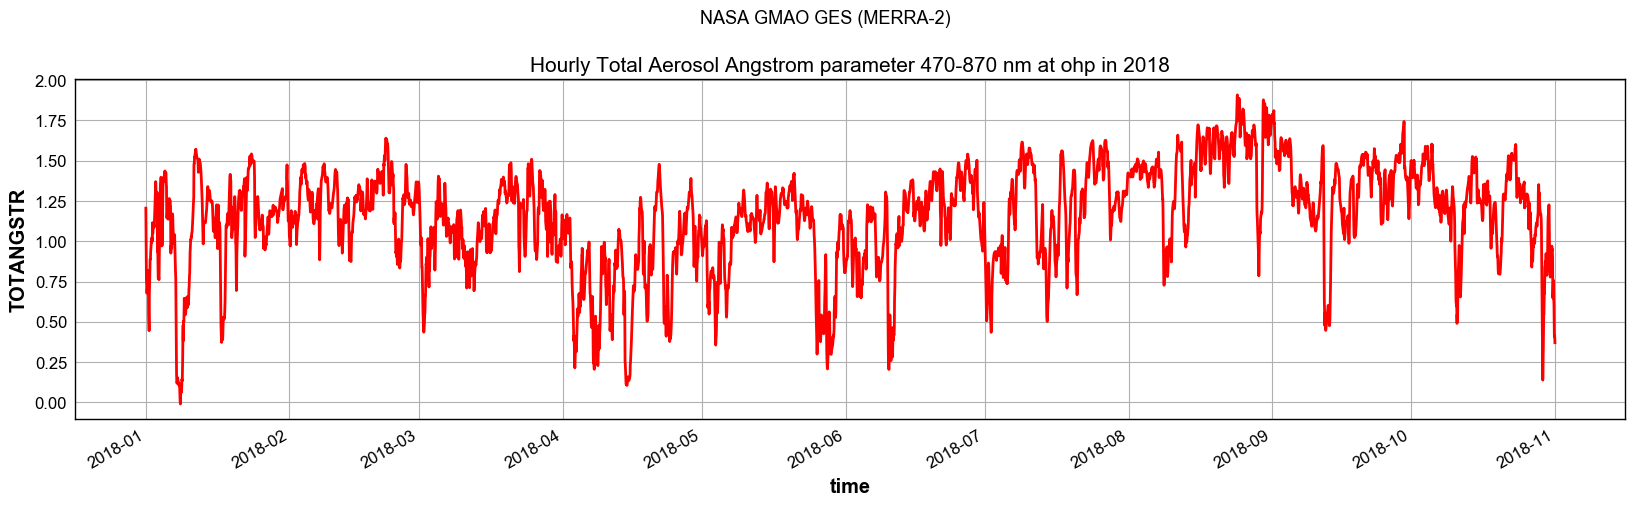

In [36]:
PlotTimeSeries(0,figfile_aer_angstr)

###  4.2)  Aerosols extinction

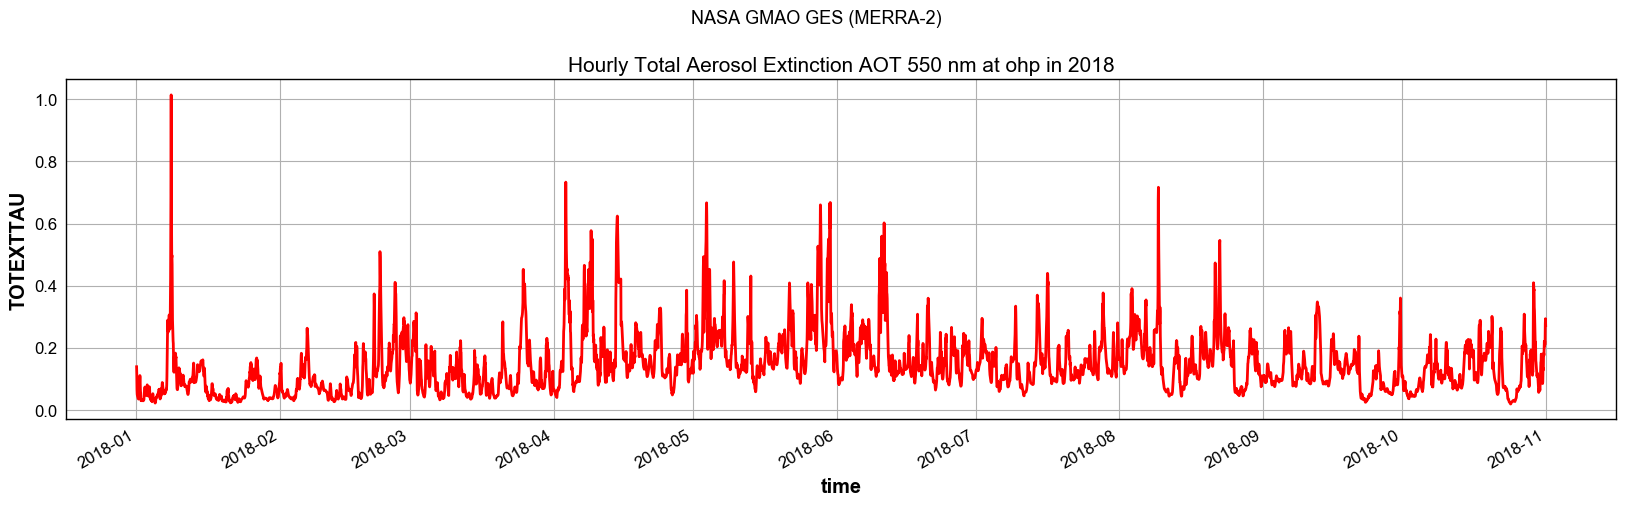

In [37]:
PlotTimeSeries(1,figfile_aer_extinct)

### 4.3) Aerosols scattering

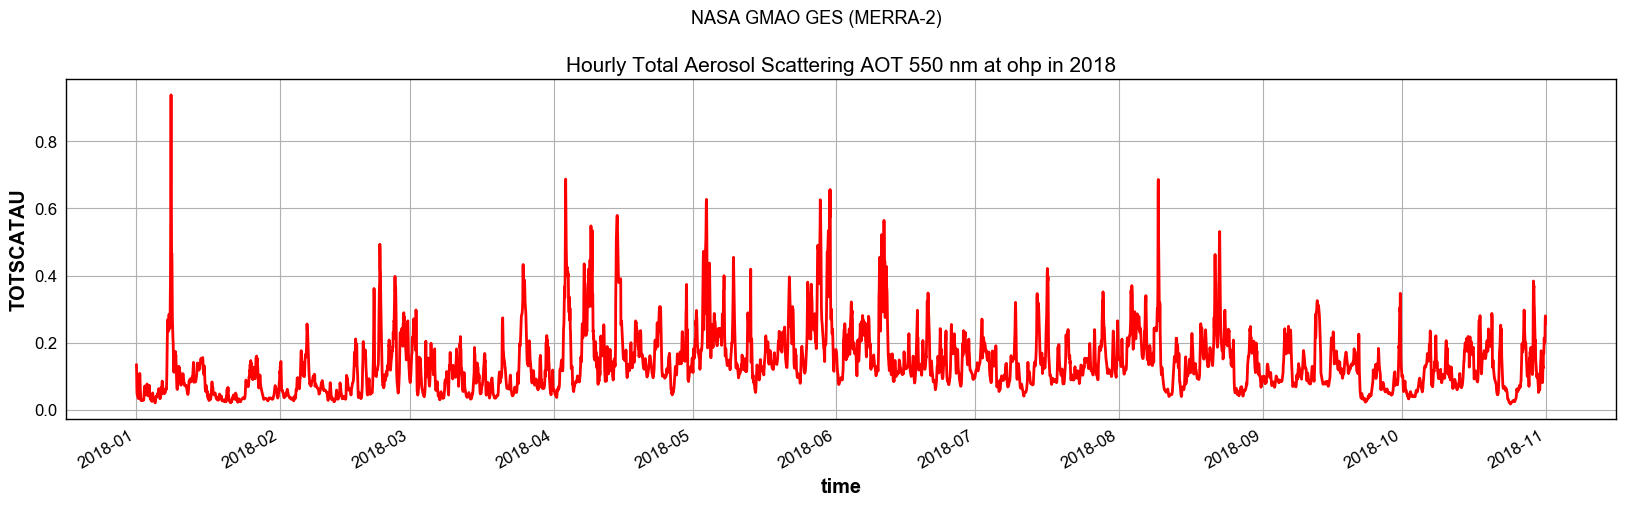

In [38]:
PlotTimeSeries(2,figfile_aer_scatter)

## 5) Output

In [39]:
df_tavg1_2d_aer_Nx.index.name='time'
df_tavg1_2d_aer_Nx.describe()

,TOTANGSTR,TOTEXTTAU,TOTSCATAU
count,7296.000000,7296.000000,7296.000000
mean,1.156152,0.147275,0.137865
std,0.312270,0.094261,0.089997
min,-0.009832,0.019636,0.016949
25%,0.987638,0.082809,0.075906
50%,1.196605,0.128361,0.119387
75%,1.372954,0.187158,0.175873
max,1.908842,1.013607,0.938630


## 5)  Save dataset  in file pandas (csv)
----------------------------------------

In [40]:
dataset=df_tavg1_2d_aer_Nx

In [41]:
dataset.index.name='time'

In [42]:
dataset.describe()

,TOTANGSTR,TOTEXTTAU,TOTSCATAU
count,7296.000000,7296.000000,7296.000000
mean,1.156152,0.147275,0.137865
std,0.312270,0.094261,0.089997
min,-0.009832,0.019636,0.016949
25%,0.987638,0.082809,0.075906
50%,1.196605,0.128361,0.119387
75%,1.372954,0.187158,0.175873
max,1.908842,1.013607,0.938630


In [43]:
dataset.head()

,TOTANGSTR,TOTEXTTAU,TOTSCATAU
time,,,
2018-01-01 00:30:00,1.205786,0.139384,0.133389
2018-01-01 01:30:00,1.031252,0.114049,0.109637
2018-01-01 02:30:00,0.825740,0.066395,0.063274
2018-01-01 03:30:00,0.762376,0.051468,0.048648
2018-01-01 04:30:00,0.734917,0.046664,0.043992


In [44]:
dataset.to_csv(pandas_filename)

In [45]:
saved_dataset=pd.read_csv(pandas_filename)

In [46]:
saved_dataset.head()

,time,TOTANGSTR,TOTEXTTAU,TOTSCATAU
0,2018-01-01 00:30:00,1.205785,0.139384,0.133389
1,2018-01-01 01:30:00,1.031252,0.114049,0.109637
2,2018-01-01 02:30:00,0.825740,0.066395,0.063274
3,2018-01-01 03:30:00,0.762376,0.051468,0.048648
4,2018-01-01 04:30:00,0.734917,0.046664,0.043992


## 6) Convert dataset into a table and then save in a fits file
--------------------------------------------------------------------------

In [47]:
table = Table.from_pandas(saved_dataset)

In [48]:
table

time,TOTANGSTR,TOTEXTTAU,TOTSCATAU
str19,float64,float64,float64
2018-01-01 00:30:00,1.2057855,0.13938414,0.13338949
2018-01-01 01:30:00,1.0312523999999998,0.11404913,0.10963678
2018-01-01 02:30:00,0.8257403,0.06639538,0.06327395
2018-01-01 03:30:00,0.7623762,0.05146834,0.04864759
2018-01-01 04:30:00,0.73491734,0.046664238,0.043991845
2018-01-01 05:30:00,0.68878126,0.0449097,0.042306982
2018-01-01 06:30:00,0.6768901999999999,0.04233465,0.039771232999999996
2018-01-01 07:30:00,0.70476013,0.039588846000000004,0.03704057
2018-01-01 08:30:00,0.7070224,0.037502932999999995,0.03508896


In [49]:
table.write(fits_filename,format='fits',overwrite=True)